In [ ]:
import sys
import os
# Get the current working directory
current_dir = os.getcwd()
# Get the parent directory path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(f"Current directory: {current_dir}\nParent directory: {parent_dir}")
# Add the parent directory to sys.path if it's not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(f"Updated sys.path: {sys.path}")

Current directory:: /Bangalore-Urban-Flood-Extent-Prediction/notebooks
Parent directory: /Projects
Updated sys.path: ['/Projects/Bangalore-Urban-Flood-Extent-Prediction', '/home/floodai/anaconda3/envs/shivam/lib/python310.zip', '/home/floodai/anaconda3/envs/shivam/lib/python3.10', '/home/floodai/anaconda3/envs/shivam/lib/python3.10/lib-dynload', '', '/home/floodai/anaconda3/envs/shivam/lib/python3.10/site-packages']


In [29]:
%matplotlib inline

In [3]:
from config import project_config
import importlib
importlib.reload(project_config)
from src.utils.log_config import setup_log
from src.utils import plots
# from src.data.data_loader import DataLoader

In [4]:
padded_pixel_value = -99999.0  # unique for padding


In [5]:
TARGET_STATE = "Karnataka"  
TARGET_DISTRICT = "Bangalore Urban" 
safe_district_name = TARGET_DISTRICT.replace(" ", "_").replace("/", "_")

In [ ]:
from src.data.make_dataset import FloodDataset

In [8]:
# Setting up the device cuda or cpu as per the availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
pad_val = -99999.0
nodata_dict = {
    "VH": None,"VV": None,"dVH": None,"dVV": None,
    "DEM_elevation": -32768.0,"DEM_slope": -32768.0,
    "DEM_sin_aspect": -32768.0,"DEM_cos_aspect": -32768.0,"DEM_curvature": -32768.0,
    "HND": None,"Rainfall": None
}
channel_names = [
        "VH", "VV", "dVH", "dVV",
        "DEM_elevation", "DEM_slope", "DEM_sin_aspect", "DEM_cos_aspect", "DEM_curvature",
        "HND", "Rainfall"
    ]

#### Masked BCE loss function

In [ ]:
from src.models.loss import masked_bce_loss

#### Evaluation setup

In [ ]:
from src.models.evaluate import evaluate_model, print_metrics, save_results, plot_confusion_matrix_total_percentage

### Model

In [ ]:
from src.models.model import BinaryModel

### Training setup

##### Using 1.4 pos weight to handle flood class imbalance. Find by analysis over number of pixels of flood and non-flood classes

In [ ]:
from src.models.train import train_model

In [14]:
# Normalizing features other than sentinel1
# Running same with 50 epochs
# 1) Create dataset
import json
feature_index_path = project_config.PROCESSED_DATA_DIR / TARGET_STATE / safe_district_name / "features_index.json"
with open(feature_index_path,"r") as f:
    feats_index = json.load(f)
all_files = [entry["features_file"] for entry in feats_index]

water_mask_threshold = -16.5

dataset = FloodDataset(
    index_list=all_files,
    transform_normalize=[4,5,6,7,8,9,10],
    # transform_normalize=[0,1,2,3],
    # transform_standardize=[4,5,6,7,8,9,10],
    pad_val=-99999.0,
    nodata_dict={"DEM_elevation": -32768.0, "DEM_slope": -32768.0, "DEM_sin_aspect": -32768.0,
                 "DEM_cos_aspect": -32768.0, "DEM_curvature": -32768.0},
    vh_threshold = water_mask_threshold
)

# 2) DataLoader (note: features is a dict -> collated to dict of batched tensors)
from torch.utils.data import DataLoader, random_split
train_n = int(0.8*len(dataset))
val_n = int(0.1*len(dataset))
test_n = len(dataset) - train_n - val_n
train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(42))

# batch_size = 4
batch_size = 64
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# --- Run Training ---
channel_names = ["VH", "VV","DEM_elevation", "DEM_slope", "HND", "Rainfall"]
# --- Model ---
model = BinaryModel(in_channels=5, out_channels=1)
# model = BinaryModelDeeper(in_channels=7, out_channels=1) # Unet with deeper MLP

# epochs = 50
epochs = 100

tag = f"final_th_16_5_features_{len(channel_names)}_epochs_{epochs}"
model_dir = project_config.OUTPUT_DIR / tag / "model"
os.makedirs(model_dir, exist_ok=True)

plots_dir = project_config.OUTPUT_DIR / tag / "Plots"
os.makedirs(plots_dir, exist_ok=True)

model, best_val_loss= train_model(
                    model, train_loader, val_loader,
                    epochs=epochs, 
                    pad_val=pad_val, 
                    nodata_dict=nodata_dict, 
                    channel_names=channel_names,
                    model_dir=model_dir,
                    plots_dir=plots_dir
                )

# Eval
test_metrics, all_predictions, all_targets, all_masks = evaluate_model(
    model, test_loader, pad_val, nodata_dict, channel_names
)

# Print the metrics
print_metrics(test_metrics)

results_dir= project_config.OUTPUT_DIR / tag / "Results"
os.makedirs(results_dir, exist_ok=True)

save_results(metrics=test_metrics, predictions=all_predictions, targets=all_predictions, masks=all_masks, save_dir=results_dir)


cf_matrix_dir = plots_dir / "Confusion Matrix"
os.makedirs(cf_matrix_dir, exist_ok=True)
plot_confusion_matrix_total_percentage(all_predictions.numpy(), all_targets.numpy(), all_masks.numpy(), cf_matrix_dir)


Epoch 1/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 0: Train=0.8242, Val=0.8185
✓ New best model saved at epoch 1 with val loss: 0.8185


Epoch 2/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 1: Train=0.8160, Val=0.8154
✓ New best model saved at epoch 2 with val loss: 0.8154


Epoch 3/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 2: Train=0.8123, Val=0.8235


Epoch 4/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 3: Train=0.7475, Val=0.8311


Epoch 5/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 4: Train=0.7528, Val=1.0167


Epoch 6/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 5: Train=0.7671, Val=1.1983


Epoch 7/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 6: Train=0.7406, Val=1.3594


Epoch 8/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 7: Train=0.6911, Val=0.8262


Epoch 9/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 8: Train=0.6576, Val=0.8442


Epoch 10/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 9: Train=0.8242, Val=0.8382


Epoch 11/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 10: Train=0.6804, Val=0.8415


Epoch 12/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 11: Train=0.6373, Val=0.8439


Epoch 13/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 12: Train=0.6064, Val=0.8452


Epoch 14/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 13: Train=0.5877, Val=0.5963
✓ New best model saved at epoch 14 with val loss: 0.5963


Epoch 15/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 14: Train=0.6012, Val=0.8510


Epoch 16/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 15: Train=0.5753, Val=0.7516


Epoch 17/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 16: Train=0.5565, Val=1.0039


Epoch 18/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 17: Train=0.5420, Val=0.7455


Epoch 19/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 18: Train=0.5286, Val=0.7834


Epoch 20/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 19: Train=0.5064, Val=0.7719


Epoch 21/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 20: Train=0.4963, Val=0.5953
✓ New best model saved at epoch 21 with val loss: 0.5953


Epoch 22/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 21: Train=0.4866, Val=0.6624


Epoch 23/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 22: Train=0.4803, Val=0.8201


Epoch 24/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 23: Train=0.4782, Val=0.4827
✓ New best model saved at epoch 24 with val loss: 0.4827


Epoch 25/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 24: Train=0.4650, Val=0.5723


Epoch 26/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 25: Train=0.4754, Val=0.6626


Epoch 27/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 26: Train=0.4738, Val=1.1866


Epoch 28/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 27: Train=0.4736, Val=0.5137


Epoch 29/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 28: Train=0.4640, Val=0.6369


Epoch 30/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 29: Train=0.4596, Val=0.7095


Epoch 31/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 30: Train=0.4558, Val=0.6805


Epoch 32/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 31: Train=0.4539, Val=0.5659


Epoch 33/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 32: Train=0.4487, Val=0.6065


Epoch 34/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 33: Train=0.4466, Val=0.6232


Epoch 35/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 34: Train=0.4449, Val=0.6793


Epoch 36/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 35: Train=0.4427, Val=0.6661


Epoch 37/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 36: Train=0.4395, Val=0.6994


Epoch 38/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 37: Train=0.4374, Val=0.6826


Epoch 39/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 38: Train=0.4352, Val=0.6750


Epoch 40/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 39: Train=0.4334, Val=0.6527


Epoch 41/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 40: Train=0.4333, Val=0.7155


Epoch 42/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 41: Train=0.4320, Val=0.9054


Epoch 43/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 42: Train=0.4302, Val=0.7286


Epoch 44/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 43: Train=0.4304, Val=0.7656


Epoch 45/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 44: Train=0.4288, Val=0.6542


Epoch 46/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 45: Train=0.4282, Val=0.6615


Epoch 47/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 46: Train=0.4276, Val=0.8365


Epoch 48/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 47: Train=0.4276, Val=0.7177


Epoch 49/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 48: Train=0.4267, Val=0.6796


Epoch 50/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 49: Train=0.4262, Val=0.7169


Epoch 51/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 50: Train=0.4279, Val=0.6384


Epoch 52/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 51: Train=0.4272, Val=0.6265


Epoch 53/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 52: Train=0.4261, Val=0.7331


Epoch 54/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 53: Train=0.4255, Val=0.6253


Epoch 55/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 54: Train=0.4259, Val=0.7173


Epoch 56/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 55: Train=0.4256, Val=0.5873


Epoch 57/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 56: Train=0.4254, Val=0.8879


Epoch 58/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 57: Train=0.4257, Val=0.8284


Epoch 59/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 58: Train=0.4251, Val=0.6251


Epoch 60/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 59: Train=0.4255, Val=0.7970


Epoch 61/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 60: Train=0.4257, Val=0.6420


Epoch 62/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 61: Train=0.4252, Val=0.6750


Epoch 63/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 62: Train=0.4266, Val=0.6874


Epoch 64/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 63: Train=0.4257, Val=0.6894


Epoch 65/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 64: Train=0.4248, Val=0.6695


Epoch 66/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 65: Train=0.4258, Val=0.7927


Epoch 67/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 66: Train=0.4271, Val=0.6634


Epoch 68/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 67: Train=0.4249, Val=0.7583


Epoch 69/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 68: Train=0.4256, Val=0.7886


Epoch 70/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 69: Train=0.4261, Val=0.8375


Epoch 71/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 70: Train=0.4248, Val=0.6895


Epoch 72/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 71: Train=0.4257, Val=0.8019


Epoch 73/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 72: Train=0.4262, Val=0.8392


Epoch 74/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 73: Train=0.4248, Val=0.6934


Epoch 75/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 74: Train=0.4255, Val=0.6023


Epoch 76/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 75: Train=0.4258, Val=0.7021


Epoch 77/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 76: Train=0.4248, Val=0.5550


Epoch 78/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 77: Train=0.4249, Val=0.6591


Epoch 79/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 78: Train=0.4257, Val=0.8049


Epoch 80/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 79: Train=0.4255, Val=0.6296


Epoch 81/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 80: Train=0.4249, Val=0.5814


Epoch 82/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 81: Train=0.4270, Val=0.7621


Epoch 83/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 82: Train=0.4260, Val=0.8385


Epoch 84/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 83: Train=0.4249, Val=0.7450


Epoch 85/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 84: Train=0.4260, Val=0.7359


Epoch 86/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 85: Train=0.4254, Val=0.6506


Epoch 87/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 86: Train=0.4250, Val=0.7937


Epoch 88/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 87: Train=0.4263, Val=0.7328


Epoch 89/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 88: Train=0.4248, Val=0.7449


Epoch 90/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 89: Train=0.4252, Val=0.6526


Epoch 91/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 90: Train=0.4248, Val=0.5191


Epoch 92/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 91: Train=0.4253, Val=0.8250


Epoch 93/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 92: Train=0.4262, Val=0.8005


Epoch 94/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 93: Train=0.4246, Val=0.7315


Epoch 95/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 94: Train=0.4251, Val=0.6392


Epoch 96/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 95: Train=0.4254, Val=0.8121


Epoch 97/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 96: Train=0.4243, Val=0.5204


Epoch 98/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 97: Train=0.4284, Val=0.8456


Epoch 99/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 98: Train=0.4248, Val=0.7065


Epoch 100/100 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 99: Train=0.4258, Val=0.7155
Final model saved at: /home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_16_5_features_6_epochs_100/model/final_model.pth


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]



EVALUATION METRICS
Loss:          0.717109
Accuracy:      0.6691
Precision:     0.9487
Recall:        0.2984
F1 Score:      0.4540
IoU:           0.2937
Dice Coefficient: 0.4540
Evaluated results saved to:/home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_16_5_features_6_epochs_100/Results/evaluation_results.pt
[[53.2  0.7]
 [32.3 13.8]]


### Testing by loading best trained model

In [35]:
import torch

def load_trained_model(model, model_path, device=None, optimizer_class=None):
    """
    Load a trained model from a saved checkpoint.
    
    Args:
        model_class: The model class (e.g., UNet2d, FNO2d, etc.).
        model_path (str or Path): Path to checkpoint (best_model.pth or final_model.pth).
        device (str): 'cuda' or 'cpu'. If None, auto-detect.
        optimizer_class: (Optional) torch.optim optimizer class (e.g., torch.optim.Adam).
        
    Returns:
        model: Model with loaded weights.
        optimizer: Loaded optimizer state (if optimizer_class is provided).
        epoch: The epoch number at which it was saved.
        train_loss: Last training loss.
        val_loss: Last validation loss.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Initialize model
    model = model.to(device)
    model.load_state_dict(checkpoint["model_state_dict"])

    # Restore optimizer (optional)
    optimizer = None
    if optimizer_class is not None:
        optimizer = optimizer_class(model.parameters(), lr=1e-3)  # same LR as training
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", None)
    train_loss = checkpoint.get("train_loss", None)
    val_loss = checkpoint.get("val_loss", None)

    print(f"Loaded model from {model_path} (epoch {epoch}, val_loss={val_loss:.4f})")

    return model, optimizer, epoch, train_loss, val_loss


# Path to saved checkpoint
# model_path = "checkpoints/best_model.pth"
model = BinaryModel(in_channels=5, out_channels=1)

tag = f"final_th_16_5_features_6_epochs_100"
model_dir = project_config.OUTPUT_DIR / tag / "model"
model_path = model_dir / "best_model.pth"

# Load model + optimizer
model, optimizer, epoch, train_loss, val_loss = load_trained_model(
    model=model, 
    model_path=model_path, 
    optimizer_class=torch.optim.Adam  # optional
)




Loaded model from /home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_16_5_features_6_epochs_100/model/best_model.pth (epoch 24, val_loss=0.4827)


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]



EVALUATION METRICS
Loss:          0.487957
Accuracy:      0.8437
Precision:     0.7539
Recall:        0.9015
F1 Score:      0.8211
IoU:           0.6965
Dice Coefficient: 0.8211
[[48.5 11.7]
 [ 3.9 35.9]]
Confusion matrix saved to:/home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_16_5_features_6_epochs_100/Plots/Confusion Matrix/best_model_cf.png


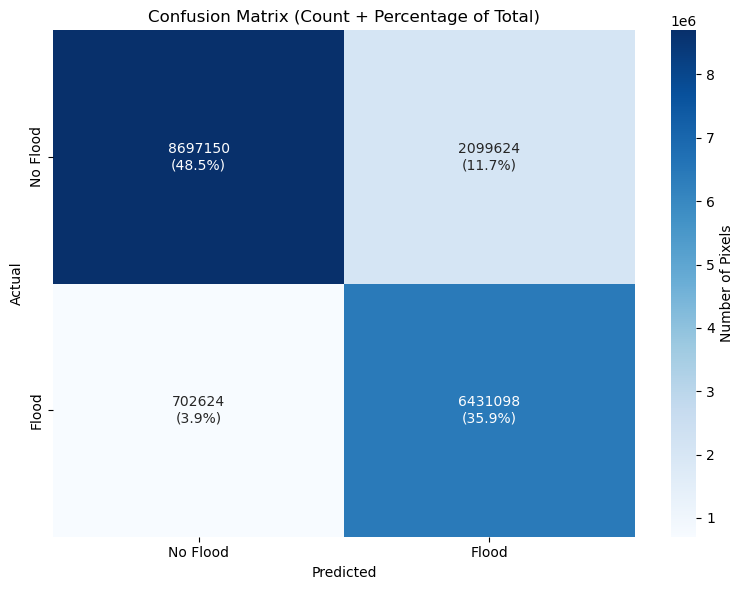

In [ ]:
dataset = FloodDataset(
    index_list=all_files,
    transform_normalize=[4,5,6,7,8,9,10],
    # transform_normalize=[0,1,2,3],
    # transform_standardize=[4,5,6,7,8,9,10],
    pad_val=-99999.0,
    nodata_dict={"DEM_elevation": -32768.0, "DEM_slope": -32768.0, "DEM_sin_aspect": -32768.0,
                 "DEM_cos_aspect": -32768.0, "DEM_curvature": -32768.0},
    vh_threshold = water_mask_threshold
)

# 2) DataLoader (note: features is a dict -> collated to dict of batched tensors)
from torch.utils.data import DataLoader, random_split
train_n = int(0.8*len(dataset))
val_n = int(0.1*len(dataset))
test_n = len(dataset) - train_n - val_n
seed = 42
train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(seed))

# batch_size = 4
batch_size = 64
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# --- Run Training ---
channel_names = ["VH", "VV","DEM_elevation", "DEM_slope", "HND", "Rainfall"]

# Eval
test_metrics, all_predictions, all_targets, all_masks = evaluate_model(
    model, test_loader, pad_val, nodata_dict, channel_names
)

# Print the metrics
print_metrics(test_metrics)

tag = f"final_th_16_5_features_6_epochs_100"
plots_dir = project_config.OUTPUT_DIR / tag / "Plots"


results_dir= project_config.OUTPUT_DIR / tag / "Results"
os.makedirs(results_dir, exist_ok=True)

# save_results(metrics=test_metrics, predictions=all_predictions, targets=all_predictions, masks=all_masks, save_dir=results_dir)


cf_matrix_dir = plots_dir / "Confusion Matrix"
os.makedirs(cf_matrix_dir, exist_ok=True)
# plot_confusion_matrix_total_percentage(all_predictions.numpy(), all_targets.numpy(), all_masks.numpy(), None)
plot_confusion_matrix_total_percentage(all_predictions.numpy(), all_targets.numpy(), all_masks.numpy(), cf_matrix_dir, "best_model_cf")



### Trying by not normalizing rainfall with -17.0 db water threshold


Epoch 1/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 0: Train=0.8003, Val=0.7966
✓ New best model saved at epoch 1 with val loss: 0.7966


Epoch 2/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 1: Train=0.7894, Val=0.9069


Epoch 3/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 2: Train=0.7140, Val=1.1068


Epoch 4/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 3: Train=0.6359, Val=2.6295


Epoch 5/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 4: Train=0.6381, Val=2.5866


Epoch 6/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 5: Train=0.5893, Val=2.3026


Epoch 7/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch 6: Train=0.5160, Val=1.2178


Epoch 8/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 7: Train=0.4780, Val=3.8352


Epoch 9/20 [Val]: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 8: Train=0.4422, Val=2.3988


Epoch 10/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 9: Train=0.4146, Val=3.8029


Epoch 11/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 10: Train=0.4040, Val=7.0717


Epoch 12/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 11: Train=0.4017, Val=0.5507
✓ New best model saved at epoch 12 with val loss: 0.5507


Epoch 13/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 12: Train=0.3864, Val=0.7619


Epoch 14/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 13: Train=0.3652, Val=2.0408


Epoch 15/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 14: Train=0.3468, Val=0.7490


Epoch 16/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch 15: Train=0.3302, Val=0.3463
✓ New best model saved at epoch 16 with val loss: 0.3463


Epoch 17/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 16: Train=0.3701, Val=1.8485


Epoch 18/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 17: Train=0.3300, Val=1.2460


Epoch 19/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 18: Train=0.3108, Val=0.4515


Epoch 20/20 [Val]: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 19: Train=0.3249, Val=1.9724
Final model saved at: /home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_17_0_features_6_epochs_20/model/final_model.pth


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]



EVALUATION METRICS
Loss:          1.938649
Accuracy:      0.4408
Precision:     0.4146
Recall:        0.9840
F1 Score:      0.5834
IoU:           0.4118
Dice Coefficient: 0.5834
[[ 4.9 55.3]
 [ 0.6 39.2]]
Confusion matrix saved to:/home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_17_0_features_6_epochs_20/Plots/Confusion Matrix/cf.png


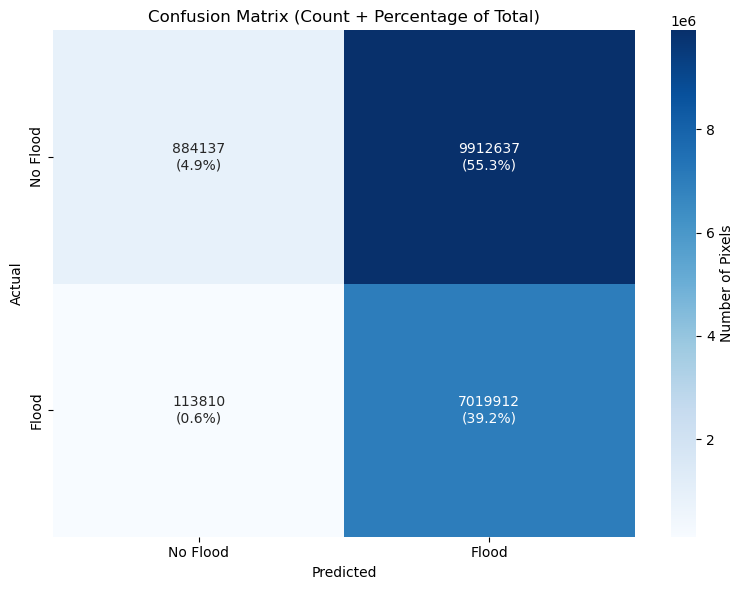

In [32]:
# Normalizing features other than sentinel1
# Running same with 50 epochs
# 1) Create dataset
import json
feature_index_path = project_config.PROCESSED_DATA_DIR / TARGET_STATE / safe_district_name / "features_index.json"
with open(feature_index_path,"r") as f:
    feats_index = json.load(f)
all_files = [entry["features_file"] for entry in feats_index]

water_mask_threshold = -17.0

dataset = FloodDataset(
    index_list=all_files,
    transform_normalize=[4,5,6,7,8,9],
    # transform_normalize=[4,5,6,7,8,9,10],
    # transform_normalize=[0,1,2,3],
    # transform_standardize=[4,5,6,7,8,9,10],
    pad_val=-99999.0,
    nodata_dict={"DEM_elevation": -32768.0, "DEM_slope": -32768.0, "DEM_sin_aspect": -32768.0,
                 "DEM_cos_aspect": -32768.0, "DEM_curvature": -32768.0},
    vh_threshold = water_mask_threshold
)

# 2) DataLoader (note: features is a dict -> collated to dict of batched tensors)
from torch.utils.data import DataLoader, random_split
train_n = int(0.8*len(dataset))
val_n = int(0.1*len(dataset))
test_n = len(dataset) - train_n - val_n
train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(42))

# batch_size = 4
batch_size = 64
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# --- Run Training ---
channel_names = ["VH", "VV","DEM_elevation", "DEM_slope", "HND", "Rainfall"]
# --- Model ---
model = BinaryModel(in_channels=5, out_channels=1)
# model = BinaryModelDeeper(in_channels=7, out_channels=1) # Unet with deeper MLP

# epochs = 50
epochs = 20

tag = f"final_th_17_0_features_{len(channel_names)}_epochs_{epochs}"
model_dir = project_config.OUTPUT_DIR / tag / "model"
os.makedirs(model_dir, exist_ok=True)

plots_dir = project_config.OUTPUT_DIR / tag / "Plots"
os.makedirs(plots_dir, exist_ok=True)

model, best_val_loss= train_model(
                    model, train_loader, val_loader,
                    epochs=epochs, 
                    pad_val=pad_val, 
                    nodata_dict=nodata_dict, 
                    channel_names=channel_names,
                    model_dir=model_dir,
                    plots_dir=plots_dir
                )

# Eval
test_metrics, all_predictions, all_targets, all_masks = evaluate_model(
    model, test_loader, pad_val, nodata_dict, channel_names
)

# Print the metrics
print_metrics(test_metrics)

results_dir= project_config.OUTPUT_DIR / tag / "Results"
os.makedirs(results_dir, exist_ok=True)

# save_results(metrics=test_metrics, predictions=all_predictions, targets=all_predictions, masks=all_masks, save_dir=results_dir)


cf_matrix_dir = plots_dir / "Confusion Matrix"
os.makedirs(cf_matrix_dir, exist_ok=True)
plot_confusion_matrix_total_percentage(all_predictions.numpy(), all_targets.numpy(), all_masks.numpy(), cf_matrix_dir)


### Evaluating on -17.0 threshold with best model

Loaded model from /home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_17_0_features_6_epochs_20/model/best_model.pth (epoch 16, val_loss=0.3463)


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]



EVALUATION METRICS
Loss:          0.344655
Accuracy:      0.8809
Precision:     0.8556
Recall:        0.8428
F1 Score:      0.8492
IoU:           0.7379
Dice Coefficient: 0.8492
[[54.6  5.7]
 [ 6.3 33.5]]
Confusion matrix saved to:/home/floodai/Desktop/Shivam/Shivam_original/Multi-Agent-Bot-Delivery-System/checkpoints/checkpoint_1100/agent_0/Thesis/Bangalore-Urban-Flood-Extent-Prediction/outputs/final_th_17_0_features_6_epochs_20/Plots/Confusion Matrix/best_model_cf.png


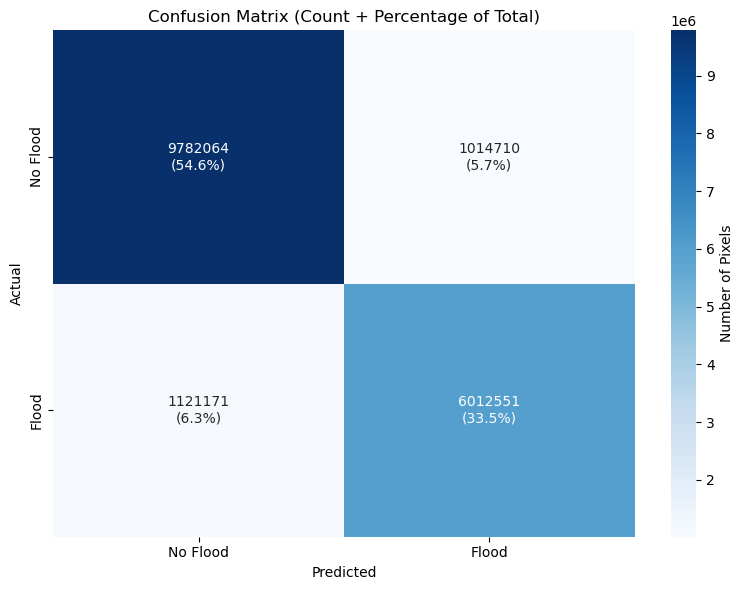

In [ ]:
# Path to saved checkpoint
# model_path = "checkpoints/best_model.pth"
model = BinaryModel(in_channels=5, out_channels=1)

# tag = f"final_th_17_0_features_6_epochs_20"
tag = f"rain_not_normalized_final_th_17_0_features_6_epochs_20"
model_dir = project_config.OUTPUT_DIR / tag / "model"
model_path = model_dir / "best_model.pth"

# Load model + optimizer
model, optimizer, epoch, train_loss, val_loss = load_trained_model(
    model=model, 
    model_path=model_path, 
    optimizer_class=torch.optim.Adam  # optional
)

# --- Run Training ---
channel_names = ["VH", "VV","DEM_elevation", "DEM_slope", "HND", "Rainfall"]

# Eval
test_metrics, all_predictions, all_targets, all_masks = evaluate_model(
    model, test_loader, pad_val, nodata_dict, channel_names
)

# Print the metrics
print_metrics(test_metrics)

# tag = f"final_th_16_5_features_6_epochs_100"


results_dir= project_config.OUTPUT_DIR / tag / "Results"
os.makedirs(results_dir, exist_ok=True)

# save_results(metrics=test_metrics, predictions=all_predictions, targets=all_predictions, masks=all_masks, save_dir=results_dir)

plots_dir = project_config.OUTPUT_DIR / tag / "Plots"
cf_matrix_dir = plots_dir / "Confusion Matrix"
os.makedirs(cf_matrix_dir, exist_ok=True)
# plot_confusion_matrix_total_percentage(all_predictions.numpy(), all_targets.numpy(), all_masks.numpy(), None)
plot_confusion_matrix_total_percentage(all_predictions.numpy(), all_targets.numpy(), all_masks.numpy(), cf_matrix_dir, "best_model_cf")
